In [1]:
from sympy.solvers import solve
from sympy.vector import *
from sympy import *
import math 
import numpy as np
from pylab import *

init_printing()

# Definition des paramètres 

In [2]:
B_NED     = Matrix([[1,0,0], [0,1,0], [0,0,1]])                              # Base dans le repère NED
B_B       = Matrix([[1,0,0], [0,1,0], [0,0,1]])                              # Base dans le repère body

omega1, omega2, omega3 = symbols('\omega_1, \omega_2, \omega_3', real=True)
Omega     = Matrix([omega1, omega2, omega3])                                    # Vecteur de rotation
 
r00, r01, r02, r10, r11, r12, r20, r21, r22 = symbols('r_{00}, r_{01}, r_{02}, r_{10}, r_{11}, r_{12}, r_{20}, r_{21}, r_{22}', real=True)
R         = Matrix([[r00,r01,r02], [r10,r11, r12], [r20, r21, r22]])                    # Matrice de rotation
R_eleron         = R * rot_axis1(45*180/np.pi)                   # Matrice de rotation
R_eleron2         = R * rot_axis1(-45*180/np.pi)                   # Matrice de rotation


Vb1,Vb2,Vb3=symbols('V_{b1} V_{b2} V_{b3}',real=True)
v_B        = Matrix([Vb1, Vb2, Vb3])                    # Vitesse du corps (repère drone)

Vw1,Vw2,Vw3=symbols('V_{w1} V_{w2} V_{w3}',real=True)
v_W        = Matrix([Vw1, Vw2, Vw3])

delta_rotor     = MatrixSymbol('delta_{rotor}', 3,1 )              # Position du corps dans le repère NED

xNED, yNED, zNED = symbols('x_{NED}, y_{NED}, z_{NED}')
X_NED     = Matrix([xNED, yNED, zNED])              # Position du corps dans le repère NED

xcp, ycp, zcp = symbols('x_{cp}, y_{cp}, z_{cp}')
X_cp     = Matrix([xcp, ycp, zcp])  
X_cp_list = np.array([Matrix([X_cp]), Matrix([X_cp]), Matrix([X_cp]), Matrix([X_cp])])

Aw1, Aw2, Aw3          = symbols('A_{w1}, A_{w2}, A_{w3}', real=True)                     # 0.5 * rho * S 
A = Symbol('A', real=True)
A_list = Matrix([Aw1, Aw1, Aw2, Aw2, Aw3])

Ch = Symbol('c_h')

VxNED, VyNED , VzNED = symbols('V_{NED_x} V_{NED_y} V_{NED_z}') 
Air_speed_earth  = Matrix([VxNED, VyNED , VzNED]) # air speed dans le repère NED

VxBody, VyBody, VzBody = symbols('V_{body_x} V_{body_y} V_{body_z}') 
Air_speed_body   = Matrix([VxBody, VyBody, VzBody])# air speed dans le repère body

omega,ct=symbols('\omega,C_t',real=True)                # vitesse de rotation des moteurs, et coefficient de poussé des helices
Cd, Cl, Ct, Cq, Ch =symbols('C_d,C_l,C_t,C_q, C_h',real=True)                # vitesse de rotation des moteurs, et coefficient de poussé des helices

motor_axis_in_body_frame = Matrix([1,0,0])

omega_rotor = symbols('\omega_{rotor}', real=True)
spinning_sense = symbols('\epsilon_{spin}', int=True)
nb_rotor = 4


Initialisation des bases des repères Body et NED

In [3]:
frontward_B = B_B[:,0]
upward_B    = B_B[:,2]
crossward_B = B_B[:,1]

frontward_NED = B_NED[:,0]
upward_NED    = B_NED[:,2]
crossward_NED = B_NED[:,1]

## Fonction générant les équations pour les efforts aérodynamiques des ailes dans le repère body 

In [4]:
def GenDirectForceWing(Omega, cp, vB, vW, R, crossward_Body):

    Air_speed_earth = vB - vW 
    Air_speed_body  = (R.T* Air_speed_earth) - cp.cross(Omega)
    VelinLDPlane    = Air_speed_body - Air_speed_body.dot(crossward_Body.T) * crossward_Body
    
    dragDirection = -VelinLDPlane / VelinLDPlane.norm()  #if VelinLDPlane_norm > VelLim else Matrix([0,0,0])
    liftDirection = crossward_Body.cross(dragDirection) #if crossward_NED.norm() > VelLim else Matrix([0,0,0])

    return VelinLDPlane, dragDirection, liftDirection

def GenForceWing(A, VelinLDPlane, dragDirection, liftDirection, Cd, Cl, cp):
    D = A * VelinLDPlane.norm()**2 * dragDirection * Cd
    L = A * VelinLDPlane.norm()**2 * liftDirection * Cl

    F_wing = L+D 
    Torque_wing =  cp.cross(F_wing)

    return F_wing, Torque_wing

def Generate_Sum_Force_wing(A_list, Omega, cp_list, R_list, vB, vW, crossward_body):
    p = 0
    Sum_Force_Wing = Matrix([0,0,0])
    Sum_Torque_Wing =  Matrix([0,0,0])
    for i in cp_list:
        VelinLDPlane, dragDirection, liftDirection = GenDirectForceWing(Omega, i, vB, vW, R_list[p], crossward_body)
        F_wing, Torque_wing =  GenForceWing(A_list[p], VelinLDPlane, dragDirection, liftDirection, Cd, Cl, i)
        Sum_Force_Wing  = Sum_Force_Wing + F_wing
        Sum_Torque_Wing = Sum_Torque_Wing + Torque_wing
        p+=1

    return Sum_Force_Wing, Sum_Torque_Wing

Génération de équations vectorielles pour les forces et les couples aéro

In [37]:
VelinLDPlane, dragDirection, liftDirection =  GenDirectForceWing(Omega, X_cp, v_B, v_W, R, crossward_B)
F, Q = GenForceWing(A, VelinLDPlane, dragDirection, liftDirection, Cd, Cl, X_cp)

Simplification de l'équation de la force produite par une aile en fonction de la vitesse et des paramètres aéro

In [7]:
F.simplify()
F

⎡                                                                             
⎢                                                                             
⎢-A⋅(C_d⋅(\omega₂⋅z_{cp} - \omega₃⋅y_{cp} + r_{00}⋅(V_{b1} - V_{w1}) + r_{10}⋅
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣A⋅(-C_d⋅(\omega₁⋅y_{cp} - \omega₂⋅x_{cp} + r_{02}⋅(V_{b1} - V_{w1}) + r_{12}⋅

                                                                              
                                                                              
(V_{b2} - V_{w2}) + r_{20}⋅(V_{b3} - V_{w3})) + Cₗ⋅(\omega₁⋅y_{cp} - \omega₂⋅x
                                                   

Simplification de l'équation du couple produit par une aile en fonction de la vitesse et des paramètres aéro

In [8]:
Q.simplify()
Q

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢A⋅(x_{cp}⋅(C_d⋅(\omega₁⋅y_{cp} - \omega₂⋅x_{cp} + r_{02}⋅(V_{b1} - V_{w1}) + 
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                                                                             

                                                                              
                                                   

Lambdification des foncionsvecteurs

In [9]:
Force_wing_function = lambdify((A, Cd, Cl, v_B, v_W, Omega, X_cp, R), F, 'sympy')
Torque_wing_function = lambdify((A, Cd, Cl, v_B, v_W, Omega, X_cp, R), Q, 'sympy')

## Génération des équations totales des surfaces

In [ ]:
cp_list = [Matrix([0,0.45,0]), Matrix([0,-0.45,0]), Matrix([-0.5,0,0]), Matrix([-0.5,0,0]), Matrix([0,0,0])]
A_list = [0.4,0.4,0.1,0.1,0.5]
R_list = [R, R, R_eleron, R_eleron2, R]

Sum_F, Sum_Q = Generate_Sum_Force_wing(A_list, Omega, cp_list, R_list, v_B, v_W, crossward_B)
#Sum_F.simplify()
#Sum_Q.simplify()

## Fonction générant les équations aérodynamiques pour les moteurs dans le repère body

In [10]:
def GenForceMoteur(Omega, ct, cq, ch, omega_rotor, cp, vB, vW, R, motor_axis_in_body_frame, spinning_sense):
    
    Air_speed_earth = vB - vW
    air_speed_in_rotor_frame = (R.T* Air_speed_earth) - cp.cross(Omega)
    Axial_speed = air_speed_in_rotor_frame.dot(motor_axis_in_body_frame)
    lat_speed = air_speed_in_rotor_frame - (Axial_speed * (motor_axis_in_body_frame))
        
    T = ct*omega_rotor**2
    H = ch * omega_rotor
    
    T_vec = T * motor_axis_in_body_frame - H * lat_speed
    
    torque = - omega_rotor * cq * lat_speed
    torque = - spinning_sense * cq * T * motor_axis_in_body_frame 
    torque_at_body_center = torque + cp.cross(T_vec.T)
        
    return T_vec, torque_at_body_center

def Generate_Sum_Force_Moteur(Omega, ct, cq, ch, omega_rotor, cp_list, vB, vW, R, motor_axis_in_body_frame_list, spinning_sense_list):
    p = 0
    Sum_Force_Rotor = Matrix([0,0,0])
    Sum_Torque_Rotor =  Matrix([0,0,0])
    for cp in cp_list:
        F_rotor, Q_rotor = GenForceMoteur(Omega, ct, cq, ch, omega_rotor, cp, vB, vW, R, motor_axis_in_body_frame_list, spinning_sense_list[p])        
        Sum_Force_Rotor  = Sum_Force_Rotor + F_rotor
        Sum_Torque_Rotor = Sum_Torque_Rotor + Q_rotor
        p+=1

    return Sum_Force_Rotor, Sum_Torque_Rotor

In [41]:
Force_rotor, Torque_rotor = GenForceMoteur(Omega, Ct, Cq, Ch, omega_rotor, X_cp, v_B, v_W, R, motor_axis_in_body_frame, spinning_sense)

In [42]:
Force_rotor

⎡                                                                           2 
⎢                                                          Cₜ⋅\omega_{rotor}  
⎢                                                                             
⎢-\omega_{rotor}⋅cₕ⋅(-\omega₁⋅z_{cp} + \omega₃⋅x_{cp} + r_{01}⋅(V_{b1} - V_{w1
⎢                                                                             
⎣-\omega_{rotor}⋅cₕ⋅(\omega₁⋅y_{cp} - \omega₂⋅x_{cp} + r_{02}⋅(V_{b1} - V_{w1}

                                                         ⎤
                                                         ⎥
                                                         ⎥
}) + r_{11}⋅(V_{b2} - V_{w2}) + r_{21}⋅(V_{b3} - V_{w3}))⎥
                                                         ⎥
) + r_{12}⋅(V_{b2} - V_{w2}) + r_{22}⋅(V_{b3} - V_{w3})) ⎦

Génération des équations des forces des moteurs

In [15]:
Torque_rotor

⎡                                       2                                     
⎢- C_q⋅Cₜ⋅\epsilon_{spin}⋅\omega_{rotor}  - \omega_{rotor}⋅cₕ⋅y_{cp}⋅(\omega₁⋅
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                                                                             

                                                                              
y_{cp} - \omega₂⋅x_{cp} + r_{02}⋅(V_{b1} - V_{w1}) + r_{12}⋅(V_{b2} - V_{w2}) 
                                                                              
                   2                                                          
  Cₜ⋅\omega_{rotor} ⋅z_{cp} + \omega_{rotor}⋅cₕ⋅x_{

Lambdififcation des fonctions pour les forces moteurs

In [38]:
Force_rotor_function = lambdify((Ct, Ch, omega_rotor, v_B, v_W, R, Omega, X_cp), Force_rotor)
Torque_rotor_function = lambdify((Cq, Ct, Ch,omega_rotor, Omega, R, v_B, v_W, X_cp, spinning_sense), Torque_rotor)

## Génération des équations pour les 4 moteurs

In [ ]:
cp_list_rotor = [Matrix([0.2,0.45,0]), Matrix([0.2,-0.45,0]), Matrix([-0.2,0.45,0]), Matrix([0.2,-0.45,0])]
spinning_sense_list = [1,-1,1,-1]

Sum_F_rotor, Sum_Q_rotor = Generate_Sum_Force_Moteur(Omega, Ct, Cq, Ch, omega_rotor, cp_list_rotor, v_B, v_W, R, motor_axis_in_body_frame, spinning_sense_list)
Sum_F_rotor.simplify()
Sum_F_rotor

In [45]:
Sum_F_rotor

⎡                                                                    2        
⎢                                                 4⋅Cₜ⋅\omega_{rotor}         
⎢                                                                             
⎢-\omega_{rotor}⋅cₕ⋅(0.4⋅\omega₃ + 4⋅r_{01}⋅(V_{b1} - V_{w1}) + 4⋅r_{11}⋅(V_{b
⎢                                                                             
⎣\omega_{rotor}⋅cₕ⋅(0.4⋅\omega₂ - 4⋅r_{02}⋅(V_{b1} - V_{w1}) - 4⋅r_{12}⋅(V_{b2

                                          ⎤
                                          ⎥
                                          ⎥
2} - V_{w2}) + 4⋅r_{21}⋅(V_{b3} - V_{w3}))⎥
                                          ⎥
} - V_{w2}) - 4⋅r_{22}⋅(V_{b3} - V_{w3})) ⎦

In [44]:
Sum_Q_rotor

⎡                                              -\omega_{rotor}⋅cₕ⋅(0.81⋅\omega
⎢                                                                             
⎢\omega_{rotor}⋅cₕ⋅(-0.18⋅\omega₁ - 0.16⋅\omega₂ + 0.4⋅r_{02}⋅(V_{b1} - V_{w1}
⎢                                                                             
⎣       -\omega_{rotor}⋅cₕ⋅(0.16⋅\omega₃ + 0.4⋅r_{01}⋅(V_{b1} - V_{w1}) + 0.4⋅

₁ + 0.18⋅\omega₂)                                               ⎤
                                                                ⎥
) + 0.4⋅r_{12}⋅(V_{b2} - V_{w2}) + 0.4⋅r_{22}⋅(V_{b3} - V_{w3}))⎥
                                                                ⎥
r_{11}⋅(V_{b2} - V_{w2}) + 0.4⋅r_{21}⋅(V_{b3} - V_{w3}))        ⎦

# Test des fonctions 

## Efforts des ailes

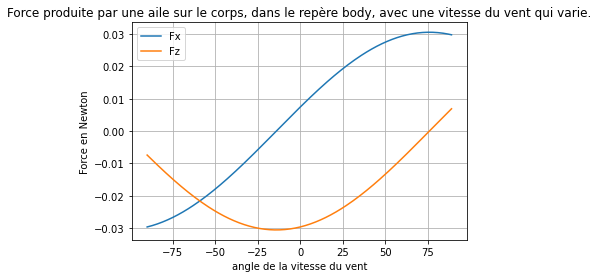

In [17]:
theta      = np.arange(-90, 90, 1) * np.pi/180
vB_test    = Matrix([0,0,0])

omega_test = Matrix([0,0,0])
R_test     = Matrix([[1,0,0],[0,1,0],[0,0,1]])
xcp_test   = Matrix([0,0.5,0])
cl_test    = 0.8
cd_test    = 0.2
A_test     = 0.037
Fx=[]
Fz=[]
for i in theta : 
    vW_test = Matrix([np.cos(i),0,np.sin(i)])
    F_test  = Force_wing_function(A_test, cd_test, cl_test, vB_test, vW_test, omega_test, xcp_test, R_test)
    Fx = np.append(Fx, F_test[0])
    Fz = np.append(Fz, F_test[2])
plt.plot(theta*180/np.pi, Fx, label=('Fx'))
plt.plot(theta*180/np.pi, Fz, label=('Fz'))
plt.grid()
plt.xlabel('angle de la vitesse du vent')
plt.ylabel('Force en Newton')
plt.title('Force produite par une aile sur le corps, dans le repère body, avec une vitesse du vent qui varie.')
plt.legend()

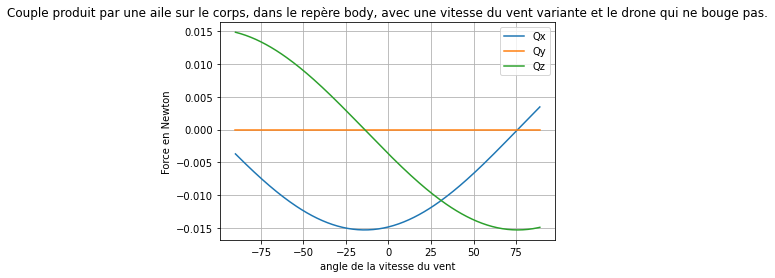

In [18]:
Qx=[]
Qy=[]
Qz=[]
for i in theta : 
    vW_test = Matrix([np.cos(i),0,np.sin(i)])
    Qtest = Torque_wing_function(A_test, cd_test, cl_test, vB_test, vW_test, omega_test, xcp_test, R_test)
    Qx=np.append(Qx,Qtest[0])
    Qy=np.append(Qy,Qtest[1])
    Qz=np.append(Qz,Qtest[2])

plt.plot(theta*180/np.pi, Qx, label=('Qx'))
plt.plot(theta*180/np.pi, Qy, label=('Qy'))
plt.plot(theta*180/np.pi, Qz, label=('Qz'))
plt.grid()
plt.xlabel('angle de la vitesse du vent')
plt.ylabel('Force en Newton')
plt.title('Couple produit par une aile sur le corps, dans le repère body, avec une vitesse du vent variante et le drone qui ne bouge pas.')
plt.legend()

Test des fonctions des efforts des moteurs

[]


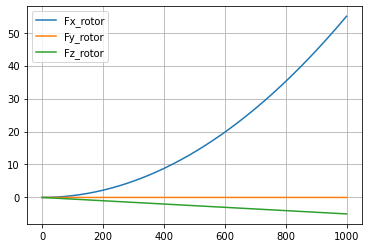

In [31]:
R_test = Matrix([[1,0,0],[0,1,0],[0,0,1]])
Ct_test = 1.1e-4 /2 
vW_test = ([0,0,0])
vB_test = ([1,0, 1])
xcp_test = ([0,0.5,0])
omega_rotor_test = np.arange(0.0001, 1, 0.0001)* 1000
Ch_test = 0.005

Force_rotor_test = Force_rotor_function(Ct_test, Ch_test, omega_rotor_test, vB_test, vW_test, R_test, omega_test, xcp_test)
plt.plot(omega_rotor_test, Force_rotor_test[0][0],label=('Fx_rotor'))
if size(Force_rotor_test[1][0]) > 1 : plt.plot(omega_rotor_test, Force_rotor_test[1][0],label=('Fy_rotor'))
if size(Force_rotor_test[2][0]) > 1 : plt.plot(omega_rotor_test, Force_rotor_test[2][0],label=('Fz_rotor'))
plt.legend()
plt.grid()
print(omega_rotor_test[:0])

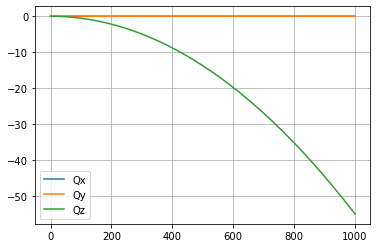

In [28]:
theta = np.arange(-90, 90, 1) * np.pi/180
vW_test = ([0,0,0])
vB_test = ([1,0,0])
xcp_test = ([0,0.5,0])
R_test = Matrix([[1,0,0],[0,1,0],[0,0,1]])
Ct_test = 1.1e-4
omega_rotor_test = np.arange(0.0001, 1, 0.0001)*1000
omega_test = ([0,0,0])
Cq_test = 0.00005
Ch_test = 0.005
spinning_sense_test = 1

Torque_rotor_test= Torque_rotor_function(Cq_test, Ct_test, Ch_test, omega_rotor_test, omega_test, R_test, vB_test, vW_test, xcp_test, spinning_sense_test)
plt.plot(omega_rotor_test, Torque_rotor_test[0][0],label='Qx')
plt.plot(omega_rotor_test, Torque_rotor_test[1][0],label='Qy')
plt.plot(omega_rotor_test, Torque_rotor_test[2][0],label='Qz')
plt.grid()
plt.legend()



## Definition de l'angle d'attaque

In [84]:
def compute_alpha(dragDirection, liftDirection, frontward_Body, VelinLDPlane): 
    calpha= dragDirection.dot(frontward_Body)
    absalpha= acos(calpha)
    signalpha = sign(liftDirection.dot(frontward_Body)) 
    if VelinLDPlane.norm()>1e-7 :
        alpha = signalpha*absalpha 
    else :
        alpha=0
    if abs(alpha)>0.5*np.pi:
        if alpha>0 :alpha=alpha-np.pi 
        else: alpha=alpha+np.pi
    return alpha

In [90]:
vB = Matrix([1,0,-1])
vW = Matrix([0,0,0])
R = Matrix([[1,0,0],[0,1,0],[0,0,1]])
Omega = Matrix([0,0,0])
VelinLDPlane, dragDirection, liftDirection = GenDirectForceWing(Omega, Matrix([0,0,0]), vB, vW, R, crossward_B)

a = compute_alpha(dragDirection,liftDirection,frontward_B, VelinLDPlane)
print(float(a*180/np.pi))

-44.99999999999999
